# House Price Predictor



# Step 1: Load and Explore the Data

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Preview first few rows
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step 2: Explore Target Variable

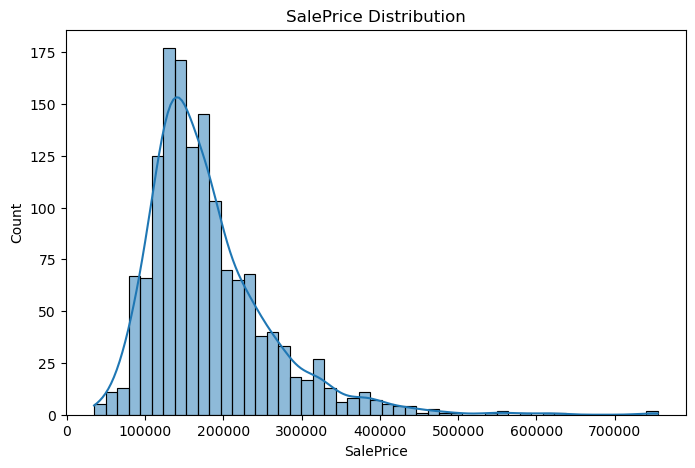

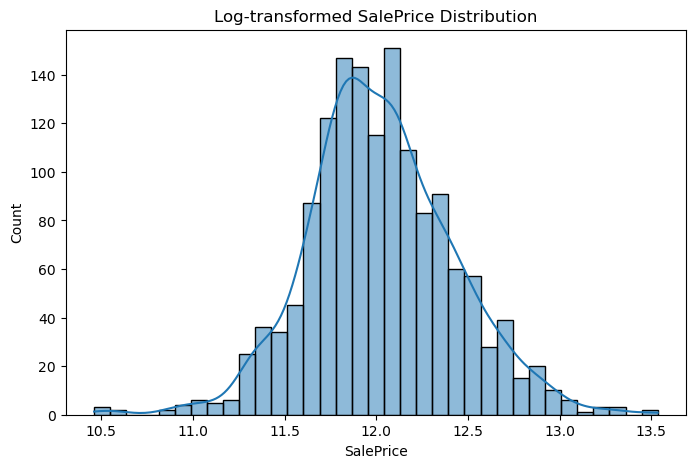

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Distribution of SalePrice
plt.figure(figsize=(8,5))
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.show()

# Log transform the SalePrice
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(train["SalePrice"]), kde=True)
plt.title("Log-transformed SalePrice Distribution")
plt.show()


# Step 3: Missing Values Analysis

In [3]:
# Count missing values in each column
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Number of features with missing values:", len(missing))
missing.head(20)   # show top 20



Number of features with missing values: 19


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

# Step 4: Quick Heatmap of Missing Data (optional visualization)

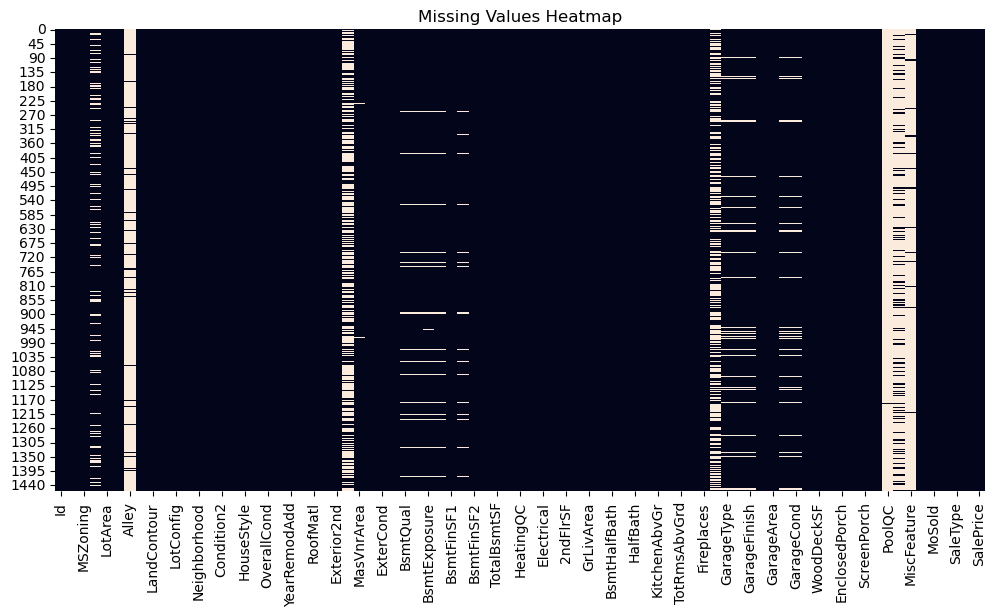

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


# Step 5: Split Numerical vs Categorical Features

In [5]:
# Separate numerical and categorical columns
num_features = train.select_dtypes(include=["int64", "float64"]).drop(["SalePrice", "Id"], axis=1).columns
cat_features = train.select_dtypes(include=["object"]).columns

print("Number of numerical features:", len(num_features))
print("Number of categorical features:", len(cat_features))

print("\nSample numerical features:", list(num_features[:10]))
print("Sample categorical features:", list(cat_features[:10]))


Number of numerical features: 36
Number of categorical features: 43

Sample numerical features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']
Sample categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']


# Step 6: Preprocessing Pipelines

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numerical pipeline: fill missing with median + scale
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: fill missing with most_frequent + one-hot encode
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


# Step 7: Build Model Pipeline

In [8]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Full pipeline: preprocessing + model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=10))
])

# Target: use log-transformed SalePrice
y = np.log1p(train["SalePrice"])
X = train.drop(["SalePrice", "Id"], axis=1)

# Cross-validation (Root Mean Squared Error on log target)
scores = -cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error")
print("Average CV RMSE:", scores.mean())


Average CV RMSE: 0.14002205321789646


# Step 8: Train on Full Data & Predict Test Set

In [9]:
# Train on full training set
model.fit(X, y)

# Prepare test set
X_test = test.drop("Id", axis=1)

# Predict log(SalePrice) and convert back
preds = model.predict(X_test)
final_preds = np.expm1(preds)   # reverse log1p

# Create submission file
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": final_preds
})

submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")


Submission file created successfully!
